Training of the model in the previous notebook was rather slow, you might have thought. This was the case even if your machine has a GPU available. But don't be disappointed yet. The truth is that we have not made use of the GPU at all just yet. Usage of devices has to be handled manually by the user in torch. First we will check if torch recognizes any devices it could use for accelerating training.

In [1]:
import torch

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 0 	chosen device: cpu 	use_cuda= False


In [3]:
from torch.utils.data import DataLoader
from data import DSBData, get_dsb2018_train_files

In [4]:
from monai.networks.nets import BasicUNet

In [5]:
train_img_files, train_lbl_files = get_dsb2018_train_files()

train_data = DSBData(
    image_files=train_img_files,
    label_files=train_lbl_files,
    target_shape=(256, 256)
)

print(len(train_data))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)

100%|██████████████████████████████████████| 382/382 [00:14<00:00, 26.82it/s]

232


In [6]:
model = BasicUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    features=[16, 16, 32, 64, 128, 16],
    act="relu",
    norm="batch",
    dropout=0.25,
)

# transfer the model to the chosen device
model = model.to(device)

BasicUNet features: (16, 16, 32, 64, 128, 16).


Training of a neural network means updating its parameters (weights) using a strategy that involves the gradients of a loss function with respect to the model parameters in order to adjust model weights to minimize this loss.

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
init_params = list(model.parameters())[0].clone().detach()

Such a training is performed by iterating over the batches of the training dataset multiple times. Each full iteration over the dataset is termed an epoch.

In [8]:
max_nepochs = 1
log_interval = 1
model.train(True)

# expects raw unnormalized scores and combines sigmoid + BCELoss for better
# numerical stability.
# expects B x C x W x D
loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in range(1, max_nepochs + 1):
    for batch_idx, (X, y) in enumerate(train_loader):
        # the inputs and labels have to be on the same device as the model
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()

        prediction_logits = model(X)
        
        batch_loss = loss_function(prediction_logits, y)

        batch_loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch:",
                epoch,
                "Batch:",
                batch_idx,
                "Total samples processed:",
                (batch_idx + 1) * train_loader.batch_size,
                "Loss:",
                batch_loss.item(),
            )

Train Epoch: 1 Batch: 0 Total samples processed 32 Loss: 0.6253708004951477
Train Epoch: 1 Batch: 1 Total samples processed 64 Loss: 0.584638774394989
Train Epoch: 1 Batch: 2 Total samples processed 96 Loss: 0.5572016835212708
Train Epoch: 1 Batch: 3 Total samples processed 128 Loss: 0.5338528752326965
Train Epoch: 1 Batch: 4 Total samples processed 160 Loss: 0.5159095525741577
Train Epoch: 1 Batch: 5 Total samples processed 192 Loss: 0.5010771751403809
Train Epoch: 1 Batch: 6 Total samples processed 224 Loss: 0.4909608066082001
Train Epoch: 1 Batch: 7 Total samples processed 256 Loss: 0.4821679890155792


In [9]:
final_params = list(model.parameters())[0].clone().detach()
assert not torch.allclose(init_params, final_params)

## Look at some predictions

Now that the model has been trained for a little bit, we are looking at the predictions again. Usually model training has to be peformed longer, so don't expect any wonders. Also keep in mind that the predictions here are based on the data the model was trained on. Those predictions might be far better than those on data not used during training. But this is a story for later.

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Predictions')

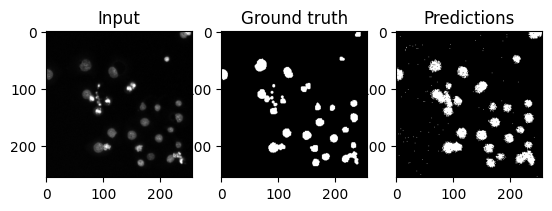

In [11]:
# convert to 0/1 range on each pixel
prediction = torch.nn.functional.sigmoid(prediction_logits)
prediction_binary = (prediction > 0.5).to(torch.uint8)

sidx = 0
plt.subplot(131)
plt.imshow(X[sidx, 0].numpy(), cmap="gray")
plt.title("Input")

plt.subplot(132)
plt.imshow(y[sidx, 0].numpy(), cmap="gray")
plt.title("Ground truth")

plt.subplot(133)
plt.imshow(prediction_binary.detach()[sidx, 0].numpy(), cmap="gray")
plt.title("Predictions")